In [1]:
import polars as pl
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.cm as cm

group_dir = "/home/ubuntu/gigabit"
exp_id    = "gigabit_attack_50sec_with_tcpdump"

In [2]:
# Read the group's entire data

lazy_results_df = (
  pl.scan_parquet(f"{group_dir}/results.parquet")
)

configurations_df = (
  pl.read_parquet(f"{group_dir}/configurations.parquet")
)

metrics_df = (
  pl.read_parquet(f"{group_dir}/metrics.parquet")
)
pd_metrics_df = (
  metrics_df
  .to_pandas()
  .sort_values(by=["node_type", "trial", "observation_timestamp"])
)

pd_metrics_df

,node_type,metric_type,trial,metric_value,observation_timestamp,exp_id
1581,originserver,cpu_utilization,1,3.3,0,gigabit_attack_100sec_with_tcpdump
1881,originserver,memory_utilization,1,245.0,0,gigabit_attack_100sec_with_tcpdump
11090,originserver,cpu_utilization,1,2.4,0,gigabit_attack_100sec_without_tcpdump
11390,originserver,memory_utilization,1,238.0,0,gigabit_attack_100sec_without_tcpdump
11391,originserver,memory_utilization,1,237.0,0,gigabit_attack_100sec_without_tcpdump
...,...,...,...,...,...,...
17442,proxy,memory_utilization,3,8787.0,300,gigabit_attack_100sec_without_tcpdump
26985,proxy,memory_utilization,3,7923.0,300,gigabit_attack_50sec_with_tcpdump
26986,proxy,memory_utilization,3,7922.0,300,gigabit_attack_50sec_with_tcpdump
36524,proxy,memory_utilization,3,8147.0,300,gigabit_attack_50sec_without_tcpdump


In [3]:
%%time

summary_df = (
  lazy_results_df
  .filter(pl.col("exp_id") == exp_id)
  .groupby(["exp_id", "node_type", "trial"])
  .agg([
    pl.count("message_marker").alias("total_messages"),
    pl.col("message_timestamp").min().alias("min_timestamp_sec"),
    pl.col("message_timestamp").max().alias("max_timestamp_sec"),
  ])
  .sort(by=["node_type", "trial"])
  .with_columns([
    (pl.col("max_timestamp_sec") - pl.col("min_timestamp_sec")).alias("active_time_sec")
  ])
  .collect()
)

summary_df

CPU times: user 15.7 s, sys: 12.7 s, total: 28.5 s
Wall time: 11.2 s


exp_id,node_type,trial,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
str,str,i32,u32,f64,f64,f64
"""gigabit_attack_50sec_with_tcpdump""","""attacker""",1,1246422,48.820384,98.600893,49.780509
"""gigabit_attack_50sec_with_tcpdump""","""attacker""",2,1250625,50.172636,100.086968,49.914332
"""gigabit_attack_50sec_with_tcpdump""","""attacker""",3,1255440,50.300207,100.217577,49.9173
"""gigabit_attack_50sec_with_tcpdump""","""client1""",1,7104,0.038092,246.4731,246.435008
"""gigabit_attack_50sec_with_tcpdump""","""client1""",2,7201,0.052103,248.871735,248.819632
"""gigabit_attack_50sec_with_tcpdump""","""client1""",3,7169,0.033531,248.971797,248.938266
"""gigabit_attack_50sec_with_tcpdump""","""originserver""",1,750692,0.137028,247.731337,247.594309
"""gigabit_attack_50sec_with_tcpdump""","""originserver""",2,746236,0.113365,249.187433,249.074068
"""gigabit_attack_50sec_with_tcpdump""","""originserver""",3,758546,0.112941,249.296122,249.183181


<IPython.core.display.Javascript object>


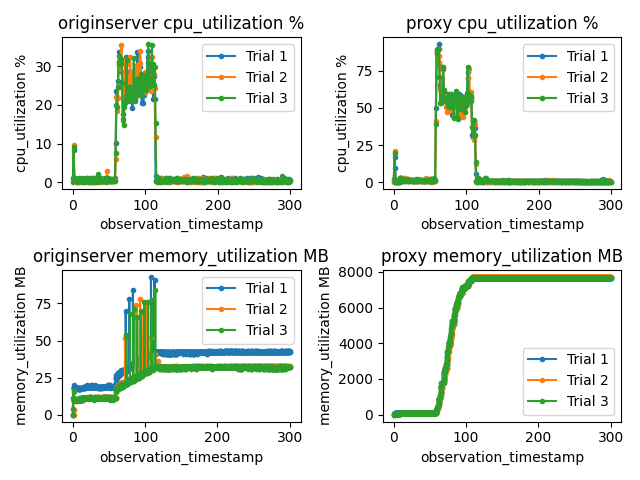

CPU times: user 652 ms, sys: 213 ms, total: 865 ms
Wall time: 501 ms


node_type,metric_type,trial,metric_value,observation_timestamp,exp_id
str,str,i64,f64,i64,str
"""proxy""","""cpu_utilization""",1,6.6,0,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,20.7,1,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,1.1,2,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,0.6,3,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,0.9,4,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,1.3,5,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,0.5,6,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,0.6,7,"""gigabit_attack_100sec_with_tcpdump"""
"""proxy""","""cpu_utilization""",1,3.6,8,"""gigabit_attack_100sec_with_tcpdump"""


In [4]:
%%time

%matplotlib notebook

# Plot the node metrics for each device

exp_pd_metrics_df = pd_metrics_df[pd_metrics_df["exp_id"] == exp_id]

metric_types = exp_pd_metrics_df.metric_type.unique()
node_names = exp_pd_metrics_df.node_type.unique()
trials = exp_pd_metrics_df.trial.unique()

metric_type_map_extension = {
    "cpu_utilization": "%",
    "memory_utilization": "MB",
}

fig, axs = plt.subplots(len(node_names), len(metric_types))
for i, mt in enumerate(metric_types):
    for j, node_name in enumerate(node_names):
        for t in trials:
            # Filter each metric type observer node into its own tile, further filter by trial
            ax = axs[i, j]
            _df = exp_pd_metrics_df[(exp_pd_metrics_df["metric_type"] == mt) 
                             & (exp_pd_metrics_df["node_type"] == node_name)
                             & (exp_pd_metrics_df["trial"] == t)]
            
            # Normalize the timestamp and metric value of the experiment
            _df["observation_timestamp"] -= min(_df["observation_timestamp"])
            _df["metric_value"] -= min(_df["metric_value"])
            
            _df.plot(kind="line", x="observation_timestamp", y="metric_value", marker=".", ax=ax, label=f"Trial {t}")

            ylabel = mt + " " + metric_type_map_extension[mt]
            ax.set_ylabel(ylabel)
            ax.set_title(node_name + " " + ylabel)

fig.tight_layout()
plt.show()

metrics_df

In [11]:
_df = (
  exp_pd_metrics_df
  .groupby(by=["node_type", "metric_type"])
  .agg(
    p95_metric_value=("metric_value", lambda s: s.quantile(0.95)),
    p99_metric_value=("metric_value", lambda s: s.quantile(0.99)),
    mean_metric_value=("metric_value", "mean"),
  )
)

_df["exp_id"] = exp_id
_df.to_csv(f"/home/ubuntu/{exp_id}.csv")

_df

p95_metric_value  p99_metric_value  \
node_type    metric_type                                              
originserver cpu_utilization               28.405            32.802   
             memory_utilization           273.000           274.000   
proxy        cpu_utilization               58.705            87.210   
             memory_utilization          7959.000          7960.000   

                                 mean_metric_value  \
node_type    metric_type                             
originserver cpu_utilization              5.618556   
             memory_utilization         266.319752   
proxy        cpu_utilization             11.552778   
             memory_utilization        5974.676684   

                                                            exp_id  
node_type    metric_type                                            
originserver cpu_utilization     gigabit_attack_50sec_with_tcpdump  
             memory_utilization  gigabit_attack_50sec_with_tcpdump  
proxy        cpu_utilization     gigabit_attack_50sec_with_tcpdump  
             memory_utilization  gigabit_attack_50sec_with_tcpdump

In [12]:
%%time

exp_results_df = (
  lazy_results_df
  .filter(pl.col("exp_id") == exp_id)
  .collect()
)

exp_results_df

CPU times: user 48.8 s, sys: 2min 6s, total: 2min 55s
Wall time: 30.8 s


message_timestamp,message_source,message_destination,message_protocol,message_size,coap_type,coap_retransmitted,coap_code,coap_message_id,coap_token,coap_proxy_uri,http_request,http_request_method,http_request_full_uri,http_response_code,http_response_code_desc,http_response_for_uri,node_type,message_marker,trial,exp_id
f64,str,str,str,i64,str,bool,str,i64,str,str,bool,str,str,i64,str,str,str,i64,i32,str
0.0,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",1,"""b379286e7795285a""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.038092,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",1,"""b379286e7795285a""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,null,null,null,"""client1""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.120073,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.131276,"""originserver""","""proxy""","""http""",462,null,null,null,null,null,null,false,null,null,200,"""ok""","""http://10.1.1.1:80/1_b379286e7795285a""","""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.137028,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,"""originserver""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.142763,"""originserver""","""proxy""","""http""",462,null,null,null,null,null,null,false,null,null,200,"""ok""","""http://10.1.1.1:80/1_b379286e7795285a""","""originserver""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.143712,"""proxy""","""client1""","""coap""",158,"""ack""",false,"""content""",1,"""b379286e7795285a""",null,null,null,null,null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.207671,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",2,"""bf18c9e183faf500""","""http://10.1.1.1:80/2_bf18c9e183faf500""",null,null,null,null,null,null,"""proxy""",2,1,"""gigabit_attack_50sec_with_tcpdump"""
0.210324,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/2_bf18c9e183faf500""",null,null,null,"""proxy""",2,1,"""gigabit_attack_50sec_with_tcpdump"""


In [13]:
%%time

client_sends_df = (
  exp_results_df
  .filter(
    (pl.col("message_source").str.contains("client"))
    & (pl.col("node_type").str.contains("client"))
  )
)
client_recvs_df = (
  exp_results_df
  .filter(
    (pl.col("message_destination").str.contains("client"))
    & (pl.col("node_type").str.contains("client"))
  )
)

rtts_df = (
  client_sends_df
  .join(
    client_recvs_df,
    on=["trial", "node_type", "message_marker"],
    how="left",
  )
  .groupby(by=["exp_id", "trial", "node_type", "message_marker"])
  .agg([
    pl.col("message_timestamp").min().alias("send_time_sec"),
    pl.col("message_timestamp_right").min().alias("recv_time_sec"),
    pl.col("message_timestamp").min().alias("first_send_time_sec"),
    pl.col("message_timestamp").max().alias("last_send_time_sec"),
    pl.col("message_timestamp_right").min().alias("first_recv_time_sec"),
    pl.col("message_timestamp_right").max().alias("last_recv_time_sec"),
    pl.col("message_timestamp").count().alias("num_send_observations"),
    pl.col("message_timestamp_right").count().alias("num_recv_observations"),
    (pl.col("coap_retransmitted") == True).sum().alias("num_retransmissions"),
  ])
  .with_columns([
    (1e3 * (pl.col("first_recv_time_sec") - pl.col("first_send_time_sec"))).alias("rtt_ms_first_transmission"),
    (1e3 * (pl.col("first_recv_time_sec") - pl.col("last_send_time_sec"))).alias("rtt_ms_last_transmission"),
  ])
  .sort(by=["exp_id", "trial", "node_type", "message_marker"])
)

stats_df = (
  rtts_df
  .groupby(by=["exp_id", "trial", "node_type"])
  .agg([
    pl.col("message_marker").n_unique().alias("num_messages"),
    pl.col("send_time_sec").min().alias("global_first_send_time_sec"),
    pl.col("recv_time_sec").max().alias("global_last_recv_time_sec"),
  ])
  .with_columns([
    (pl.col("num_messages") / (pl.col("global_last_recv_time_sec") - pl.col("global_first_send_time_sec"))).alias("average_rps"),
  ])
  .filter(
    pl.col("node_type").str.contains("client")
  )
)

rtts_df = (
  rtts_df.join(
    stats_df,
    on=["exp_id", "trial", "node_type"],
    how="left",
  )
)
  
rtts_df

CPU times: user 4.14 s, sys: 164 ms, total: 4.3 s
Wall time: 1.99 s


exp_id,trial,node_type,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,num_send_observations,num_recv_observations,num_retransmissions,rtt_ms_first_transmission,rtt_ms_last_transmission,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
str,i32,str,i64,f64,f64,f64,f64,f64,f64,u32,u32,u32,f64,f64,u32,f64,f64,f64
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",1,0.038092,0.263898,0.038092,0.038092,0.263898,0.263898,1,1,0,225.805998,225.805998,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",2,0.286592,0.343054,0.286592,0.286592,0.343054,0.343054,1,1,0,56.461811,56.461811,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",3,0.345809,0.401726,0.345809,0.345809,0.401726,0.401726,1,1,0,55.917025,55.917025,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",4,0.4046,0.460306,0.4046,0.4046,0.460306,0.460306,1,1,0,55.696011,55.696011,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",5,0.463224,0.519244,0.463224,0.463224,0.519244,0.519244,1,1,0,56.020021,56.020021,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",6,0.522002,0.577286,0.522002,0.522002,0.577286,0.577286,1,1,0,55.284023,55.284023,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",7,0.579858,0.635172,0.579858,0.579858,0.635172,0.635172,1,1,0,55.314064,55.314064,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",8,0.638322,0.693691,0.638322,0.638322,0.693691,0.693691,1,1,0,55.369139,55.369139,3547,0.038092,246.4723,14.393291
"""gigabit_attack_50sec_with_tcpdump""",1,"""client1""",9,0.696522,0.752,0.696522,0.696522,0.752,0.752,1,1,0,55.537939,55.537939,3547,0.038092,246.4723,14.393291


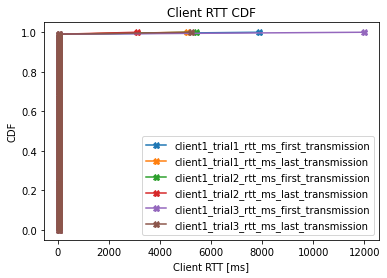

,percentile,trial,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,num_send_observations,num_recv_observations,num_retransmissions,rtt_ms_first_transmission,rtt_ms_last_transmission,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
count,101.000000,101.0,1.010000e+02,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000
mean,0.500000,3.0,9.368794e+05,138.946272,139.027685,138.946272,138.984534,139.027685,139.027685,1.019802,1.019802,0.019802,171.005302,104.170470,3580.0,0.033531,248.971044,14.381119
std,0.293002,0.0,5.483175e+05,76.188503,76.117303,76.188503,76.150240,76.117303,76.117303,0.199007,0.199007,0.199007,1186.080445,514.398813,0.0,0.000000,0.000000,0.000000
min,0.000000,3.0,1.000000e+00,0.033531,0.187367,0.033531,0.033531,0.187367,0.187367,1.000000,1.000000,0.000000,52.175999,52.175999,3580.0,0.033531,248.971044,14.381119
25%,0.250000,3.0,2.868722e+05,61.617269,67.139535,61.617269,65.481748,67.139535,67.139535,1.000000,1.000000,0.000000,52.736998,52.736998,3580.0,0.033531,248.971044,14.381119
50%,0.500000,3.0,1.257230e+06,153.069107,153.095103,153.069107,153.069107,153.095103,153.095103,1.000000,1.000000,0.000000,52.801847,52.801847,3580.0,0.033531,248.971044,14.381119
75%,0.750000,3.0,1.258125e+06,201.057052,201.069441,201.057052,201.057052,201.069441,201.069441,1.000000,1.000000,0.000000,53.147554,53.147554,3580.0,0.033531,248.971044,14.381119
max,1.000000,3.0,1.259020e+06,248.971797,248.971044,248.971797,248.971797,248.971044,248.971044,3.000000,3.000000,2.000000,11972.945929,5222.627878,3580.0,0.033531,248.971044,14.381119


In [24]:
plot_args = {
    "kind"  : "line",
    "y"     : "percentile",
    "marker": "X",
}

pd_rtts_df = rtts_df.to_pandas()

trials = pd_rtts_df["trial"].unique()
clients = pd_rtts_df["node_type"].unique()
rtts = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]

ax = None
for t in trials:
  for c in clients:
    cdfdf = pd_rtts_df[(pd_rtts_df["trial"] == t) & (pd_rtts_df["node_type"] == c)]
    cdfdf = cdfdf.quantile(q=tuple(_q/100 for _q in range(0, 101, 1))).reset_index().rename(columns={"index":"percentile"})
    for rtt in rtts:
        label = f"{c}_trial{t}_{rtt}"
        ax = cdfdf.plot(x=rtt, label=label, ax = ax, **plot_args)

ax.set_ylabel("CDF")
ax.set_xlabel("Client RTT [ms]")
ax.set_title("Client RTT CDF")
plt.show()

cdfdf.describe()

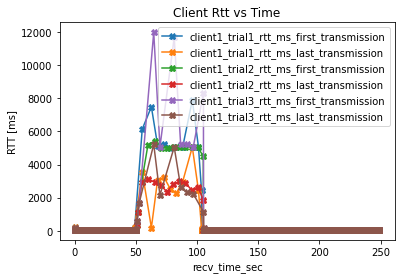

In [25]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "recv_time_sec",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = pd_rtts_df[(pd_rtts_df["trial"] == t) & (pd_rtts_df["node_type"] == c)]
        
        for rtt in rtts:
          label = f"{c}_trial{t}_{rtt}"
          ax = client_trial_df.plot(label=label, y=rtt, **plot_args, ax=ax)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

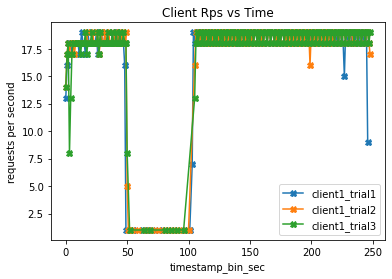

,timestamp_bin_sec,node_type,packets_per_second
0,0.0,client1,14
1,1.0,client1,17
2,2.0,client1,18
3,3.0,client1,8
4,4.0,client1,13
...,...,...,...
197,244.0,client1,18
198,245.0,client1,19
199,246.0,client1,19
200,247.0,client1,18


In [26]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "timestamp_bin_sec",
    "y"     : "packets_per_second",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    trial_df = pd_rtts_df[pd_rtts_df["trial"] == t]
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "node_type"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = time_stats_df[time_stats_df["node_type"] == c]
        
        label = f"{c}_trial{t}"
        ax = client_trial_df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

   trial   mean_rps
0      1  14.393291
1      2  14.452281
2      3  14.381119


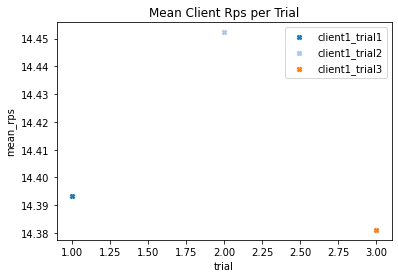

,node_type,trial,mean_rps
0,client1,1,14.393291
1,client1,2,14.452281
2,client1,3,14.381119


In [27]:
per_trial_stats_df = (
  pd_rtts_df
  .groupby(by=["node_type", "trial"])
  .agg(
    mean_rps=("average_rps", "mean")
  )
  .reset_index()
)

plot_args = {
    "kind"  : "scatter",
    "x"     : "trial",
    "y"     : "mean_rps",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

colors = iter([plt.cm.tab20(i) for i in range(20)])

ax = None
for t in trials:
    for c in clients:
        
        grouped_client_trial_df = per_trial_stats_df[(per_trial_stats_df["trial"] == t) & (per_trial_stats_df["node_type"] == c)]
        
        label = "hi"
        label=f"{c}_trial{t}"
        ax = grouped_client_trial_df.plot(ax=ax, label=label, color=[next(colors)], **plot_args)
        
print(per_trial_stats_df.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

per_trial_stats_df

In [18]:
exp_results_df

message_timestamp,message_source,message_destination,message_protocol,message_size,coap_type,coap_retransmitted,coap_code,coap_message_id,coap_token,coap_proxy_uri,http_request,http_request_method,http_request_full_uri,http_response_code,http_response_code_desc,http_response_for_uri,node_type,message_marker,trial,exp_id
f64,str,str,str,i64,str,bool,str,i64,str,str,bool,str,str,i64,str,str,str,i64,i32,str
0.0,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",1,"""b379286e7795285a""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.038092,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",1,"""b379286e7795285a""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,null,null,null,"""client1""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.120073,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.131276,"""originserver""","""proxy""","""http""",462,null,null,null,null,null,null,false,null,null,200,"""ok""","""http://10.1.1.1:80/1_b379286e7795285a""","""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.137028,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/1_b379286e7795285a""",null,null,null,"""originserver""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.142763,"""originserver""","""proxy""","""http""",462,null,null,null,null,null,null,false,null,null,200,"""ok""","""http://10.1.1.1:80/1_b379286e7795285a""","""originserver""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.143712,"""proxy""","""client1""","""coap""",158,"""ack""",false,"""content""",1,"""b379286e7795285a""",null,null,null,null,null,null,null,"""proxy""",1,1,"""gigabit_attack_50sec_with_tcpdump"""
0.207671,"""client1""","""proxy""","""coap""",104,"""con""",false,"""get""",2,"""bf18c9e183faf500""","""http://10.1.1.1:80/2_bf18c9e183faf500""",null,null,null,null,null,null,"""proxy""",2,1,"""gigabit_attack_50sec_with_tcpdump"""
0.210324,"""proxy""","""originserver""","""http""",200,null,null,null,null,null,null,true,"""get""","""http://10.1.1.1:80/2_bf18c9e183faf500""",null,null,null,"""proxy""",2,1,"""gigabit_attack_50sec_with_tcpdump"""


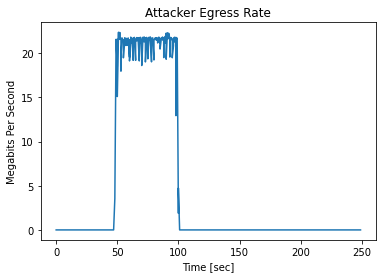

CPU times: user 58.3 s, sys: 21.7 s, total: 1min 20s
Wall time: 5.63 s


,trial,timestamp_bin,sum_bytes,megabytes_per_second,megabits_per_second
0,1,0.0,0.0,0.0,0.0
0,1,1.0,0.0,0.0,0.0
0,1,2.0,0.0,0.0,0.0
0,1,3.0,0.0,0.0,0.0
0,1,4.0,0.0,0.0,0.0
...,...,...,...,...,...
0,1,245.0,0.0,0.0,0.0
0,1,246.0,0.0,0.0,0.0
0,1,247.0,0.0,0.0,0.0
0,1,248.0,0.0,0.0,0.0


In [28]:
%%time

ratedf = (
  exp_results_df
  .filter(
    (pl.col("node_type") == "attacker")
    & (pl.col("message_destination") == "proxy")
  )
  .select(["exp_id", "trial", "message_marker", "message_timestamp", "message_size"])
  .to_pandas()
)

ratedf["timestamp_bin"] = np.floor(ratedf["message_timestamp"])
bins = list(range(configurations_df.filter(pl.col("exp_id") == exp_id)["client_duration"].min()))

tdf = ratedf.groupby(by=["trial", "timestamp_bin"]).agg(sum_bytes=('message_size', 'sum')).reset_index()

for trial in tdf.trial.unique():
    for missing_timestamp in set(bins) - set(tdf.timestamp_bin.unique()):
        _df = pd.DataFrame([[trial, missing_timestamp, 0.0]], columns=["trial", "timestamp_bin", "sum_bytes"])
        tdf = pd.concat([_df, tdf])

tdf.sort_values(by="timestamp_bin", inplace=True)
tdf["megabytes_per_second"] = 1e-6 * tdf["sum_bytes"]
tdf["megabits_per_second"] = 8 * tdf["megabytes_per_second"]

ax = tdf.plot(kind="line", x="timestamp_bin", y="megabits_per_second")
ax.set_title("Attacker Egress Rate")
ax.set_ylabel("Megabits Per Second")
ax.set_xlabel("Time [sec]")
ax.get_legend().remove()
plt.show()

tdf

In [20]:
%%time

run_dtls = configurations_df.filter(pl.col("exp_id") == exp_id)["run_proxy_with_dtls"].to_list()[0]
if run_dtls:
  attack_message_receiver = "attacker"
else:
  attack_message_receiver = "receiver"

attacker_send_df = (
  exp_results_df
  .filter(
    (pl.col("node_type") == "attacker")
    & (pl.col("message_destination") == "proxy")
  )
)

proxy_df = (
  exp_results_df
  .filter(
    (pl.col("node_type") == "proxy")
  )
)

receiver_df = (
  exp_results_df
  .filter(
    (pl.col("node_type") == attack_message_receiver)
    & (pl.col("message_destination") == attack_message_receiver)
  )
)

attack_dbg_df = (
  attacker_send_df
  .join(
    proxy_df,
    on=["exp_id", "trial", "message_marker"],
    how="left",
    suffix="_proxy"
  )
  .join(
    receiver_df,
    on=["exp_id", "trial", "message_marker"],
    how="left",
    suffix="_receiver"
  )
  .groupby(by=["exp_id", "trial", "message_marker"])
  .agg([
    pl.col("coap_code_receiver").first().alias("coap_code"),
    pl.col("message_timestamp").min().alias("first_send_time_sec"),
    (1e3 * (pl.col("message_timestamp_proxy").min() - pl.col("message_timestamp").min())).alias("attacker_to_proxy_ms"),
    (1e3 * (pl.col("message_timestamp_receiver").max() - pl.col("message_timestamp_proxy").min())).alias("proxy_to_attacker_ms"),
    (1e3 * (pl.col("message_timestamp_receiver").max() - pl.col("message_timestamp").min())).alias("attacker_to_receiver_rtt_ms"),
    pl.col("message_timestamp_receiver").min().alias("first_recv_time_sec"),
  ])
  .drop_nulls()
  .sort(by="first_send_time_sec")
)

attack_dbg_df = attack_dbg_df.to_pandas()

attack_dbg_df

CPU times: user 1min 17s, sys: 39.5 s, total: 1min 57s
Wall time: 15.5 s


,exp_id,trial,message_marker,coap_code,first_send_time_sec,attacker_to_proxy_ms,proxy_to_attacker_ms,attacker_to_receiver_rtt_ms,first_recv_time_sec
0,gigabit_attack_50sec_with_tcpdump,1,878,content,48.820384,-77.989817,93.312979,15.323162,48.835707
1,gigabit_attack_50sec_with_tcpdump,1,879,content,48.820388,-77.976942,93.965054,15.988111,48.836376
2,gigabit_attack_50sec_with_tcpdump,1,880,content,48.820389,-77.919960,171.627045,93.707085,48.914096
3,gigabit_attack_50sec_with_tcpdump,1,881,content,48.820636,-77.859879,94.817877,16.957998,48.837594
4,gigabit_attack_50sec_with_tcpdump,1,882,content,48.820640,-77.847958,96.892118,19.044161,48.839684
...,...,...,...,...,...,...,...,...,...
2999141,gigabit_attack_50sec_with_tcpdump,3,1256337,bad_gateway,100.217374,-54.948092,5033.386946,4978.438854,105.195813
2999142,gigabit_attack_50sec_with_tcpdump,3,1256338,bad_gateway,100.217411,-54.980993,5033.384085,4978.403091,105.195814
2999143,gigabit_attack_50sec_with_tcpdump,3,1256339,bad_gateway,100.217450,-54.965019,5033.330917,4978.365898,105.195816
2999144,gigabit_attack_50sec_with_tcpdump,3,1256340,bad_gateway,100.217512,-54.987192,5033.293009,4978.305817,105.195818


In [21]:
%matplotlib inline

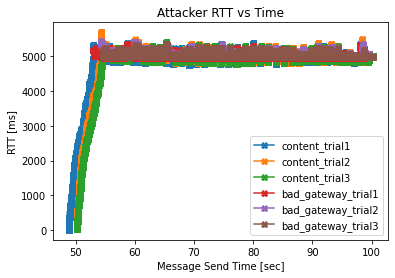

In [22]:
# Plot attacker rtt vs time

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "y": "attacker_to_receiver_rtt_ms",
  "marker": "X",
}

coap_codes = attack_dbg_df["coap_code"].unique()
trials = attack_dbg_df["trial"].unique()

ax = None
for coap_code in coap_codes:
    if coap_code is None:
        continue
    for t in trials:
      _df = attack_dbg_df[(attack_dbg_df["coap_code"] == coap_code) & (attack_dbg_df["trial"] == t)]
      label = f"{coap_code}_trial{t}"
      ax = _df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

/home/ubuntu/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


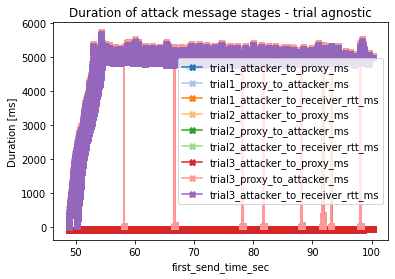

In [23]:
# Plot the duration of different stages of the attack messages

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "marker": "X",
}

colors = iter([plt.cm.tab20(i) for i in range(20)])

rtts = ["attacker_to_proxy_ms", "proxy_to_attacker_ms", "attacker_to_receiver_rtt_ms"]

ax = None
for t in trials:
  for rtt in rtts:
    label = f"trial{t}_{rtt}"
    ax = attack_dbg_df.plot(y=rtt, ax=ax, label=label, color=[next(colors)], **plot_args)

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()